# Manipulating a trajectory

This notebook shows how to read and manipulate the trajectories in which the system's configurations are stored.

In particular, we discuss the reading/writing of input trajectory files using the built-in parsers and third-party packages. We also discuss particle properties and visualization features.

## Reading a trajectory

A trajectory file can be read using the `Trajectory` class. Let us open our first trajectory file:

In [1]:
from partycls import Trajectory

traj = Trajectory('data/kalj_N150.xyz')

`Trajectory` instances are **iterable** and composed of `System` instances (*i.e.* trajectory frames):

In [2]:
# Number of frames in the trajectory
print("Number of frames:", len(traj))

Number of frames: 101


Upon reading a trajectory file, several optional parameters can be specified to read only a subset of the available frames:

- `first` is the index of the first frame to read (default is `0`).
- `last` is the index of the last frame to read (default is `None`, meaning it will read up to the last frame).
- `step` is the increment between two consecutive frames to read (default is `1`, meaning that every frame is read). For instance, `step=2` means that every 2 frames only will be read.

Example:

In [3]:
# Read the 10 first frames only
traj = Trajectory('data/kalj_N150.xyz', first=0, last=9)
print("Number of frames:", len(traj))

Number of frames: 10


Now, let us have a look at the first frame of this trajectory, which is an instance of `System`:

In [4]:
print(traj[0])

System(number_of_particles=150, species=['A' 'B'], chemical_fractions=[0.8 0.2], cell=[5. 5. 5.])


This tells us about the main features of the system: number of particles, chemical species, etc. In particular, a `System` is enclosed in an orthorhombic simulation cell , which is an instance of `Cell`.

A cell is characterized by the sizes of its sides and by whether it uses periodic boundary conditions (which are assumed by default):

In [5]:
print(traj[0].cell)

Cell(side=[5. 5. 5.], periodic=[ True  True  True], volume=125.0)


Cell properties can be accessed as instances attributes:

In [6]:
cell = traj[0].cell

print("Sides:", cell.side)
print("Periodicity:", cell.periodic)
print("Volume:", cell.volume)

Sides: [5. 5. 5.]
Periodicity: [ True  True  True]
Volume: 125.0


*partycls* accepts both 2- and 3-dimensional systems. The spatial dimension is guessed from the number of sides the cell has in the input file:

In [7]:
# Dimension
print("Spatial dimension:", traj[0].n_dimensions)

Spatial dimension: 3


A `System` is composed of a collection of particles, which are `Particle` instances. Particles can be accessed from a system via its iterable `particle` attribute:

In [8]:
# First two particles in the system
print(traj[0].particle[0])
print(traj[0].particle[1])

Particle(position=[ 0.819926 -1.760086  0.36845 ], species=A, label=-1, radius=0.5, nearest_neighbors=None, species_id=1)
Particle(position=[ 0.29098   1.24579  -2.495344], species=A, label=-1, radius=0.5, nearest_neighbors=None, species_id=1)


Particle properties will be discussed in a further section.

## Dealing with various trajectory formats

Natively, the code only reads/writes standard [XYZ](https://en.wikipedia.org/wiki/XYZ_file_format) trajectories (with a mandatory `cell` attribute in the comment line) and [RUMD](http://rumd.org/) trajectories:

In [9]:
# Open a XYZ trajectory
#  default value for `fmt` is "xyz"
traj_xyz = Trajectory('data/kalj_N150.xyz',
                      fmt='xyz')
print(traj_xyz)

# Open a RUMD trajectory
traj_rumd = Trajectory('data/kalj_N256_rho1.185_rumd.xyz.gz',
                       fmt='rumd')
print(traj_rumd)

Trajectory(filename="data/kalj_N150.xyz", number_of_frames=101)
Trajectory(filename="data/kalj_N256_rho1.185_rumd.xyz.gz", number_of_frames=1)


However, it is possible to rely on external packages to read more formats such as [LAMMPS](https://lammps.sandia.gov/), [GROMACS](https://www.gromacs.org/), etc. or even your custom trajectory formats.

These two external packages are:

* [*atooms*](https://framagit.org/atooms/atooms) - a Python framework for simulations of interacting particles.
* [*MDTraj*](https://www.mdtraj.org/1.9.5/index.html) - a Python library that allows users to manipulate molecular dynamics trajectories.

With these dependencies properly installed in the Python environment, it is possible to use them as backend when creating an instance of `Trajectory`:

### Atooms

In [10]:
# Open a LAMMPS trajectory using atooms
traj = Trajectory('data/lj_N256_rho1.0.atom', 
                  fmt='lammps',
                  backend='atooms')

print('Number of frames:', len(traj))
print(traj[0])

Number of frames: 6
System(number_of_particles=256, species=['1'], chemical_fractions=[1.], cell=[6.3496 6.3496 6.3496])


When using `backend="atooms"`, the `fmt` parameter must be set to the right trajectory format to select the appropriate parser. This is indepedent of the file extension.

### MDTraj

When using `backend="mdtraj"`, however, the file extension is used to determine the correct format (the `fmt` parameter can thus be ignored).

In [11]:
# Open a PDB trajectory using MDTraj
traj = Trajectory('data/frame0.pdb', 
                  backend='mdtraj')

print('Number of frames:', len(traj))
print(traj[0])

Number of frames: 501
System(number_of_particles=22, species=['C' 'H' 'N' 'O'], chemical_fractions=[0.27272727 0.54545455 0.09090909 0.09090909], cell=[1. 1. 1.])


An additional `top` parameter can be specified for trajectory files that require external topology information (see [*MDTraj*](https://www.mdtraj.org/) documentation). This parameter is specific to *MDTraj* and will be ignored when using atooms or native formats.

## System properties

Now that we know how to properly read a trajectory file and how `Trajectory` instances are structured, let us look at some general properties of `System` instances:

In [12]:
traj = Trajectory('data/kalj_N150.xyz', last=0)
sys = traj[0]

print('Number of spatial dimensions :', sys.n_dimensions)
print('Number of particles :', len(sys.particle))
print('Density :', sys.density)
print('Distinct species :', sys.distinct_species)
print('Chemical fractions :', sys.chemical_fractions)
print('Pairs of species :', sys.pairs_of_species)
print('Pairs of species ID :', sys.pairs_of_species_id)

Number of spatial dimensions : 3
Number of particles : 150
Density : 1.2
Distinct species : ['A' 'B']
Chemical fractions : [0.8 0.2]
Pairs of species : [('A', 'A'), ('A', 'B'), ('B', 'A'), ('B', 'B')]
Pairs of species ID : [(1, 1), (1, 2), (2, 1), (2, 2)]


The very last property, `pairs_of_species_id`, allows us to standardize the species in the trajectory, from a literal name or symbol to an integer value. Here, for example, we have:

- `"A"` → `1`
- `"B"` → `2`

In more complex cases, for instance when dealing with atomic symbols such as `"Si"`, `"C"`, `"O"`, etc., this standardization can come in handy.

## Particle properties

In a previous section, we saw that `Particle` instances are characterized by an ensemble of properties such as their position, their chemical species, etc. These properties can easily be accessed and manipulated.

In particular, particles are characterized by:

- A position vector.
- A species (chemical symbol or type).
- A radius (set to `0.5` by default).
- A label, which is the index of the cluster that particle belongs to. Its default value is `-1` but it is automatically assigned after a clustering is performed, as we will see in the [next notebook](2_workflow.html).
- A list of nearest neighbors (`None` by default).
- And more.

Such properties can be accessed as instances attributes:

In [13]:
# Isolate the first particle in the trajectory
traj = Trajectory('data/kalj_N150.xyz', last=9)
p = traj[0].particle[0]

# Some properties
print('Position:', p.position)
print('Species:', p.species)
print('Radius:', p.radius)
print('Label:', p.label)
print('Neighbors:', p.nearest_neighbors)

Position: [ 0.819926 -1.760086  0.36845 ]
Species: A
Radius: 0.5
Label: -1
Neighbors: None


An arbitrary property can also be assigned to a particle:

In [14]:
print("Before:\n", p)

# Set a mass
p.mass = 0.5
print("\nAfter:\n", p)

Before:
 Particle(position=[ 0.819926 -1.760086  0.36845 ], species=A, label=-1, radius=0.5, nearest_neighbors=None, species_id=1)

After:
 Particle(position=[ 0.819926 -1.760086  0.36845 ], species=A, label=-1, radius=0.5, nearest_neighbors=None, species_id=1, mass=0.5)


A more practical way to access particle properties is via the method `get_property()` (also called `dump()` for short), either from `System` or from `Trajectory` :

1. For a  `System`, this will return a `numpy.ndarray`:

In [15]:
# Positions of all the particles in the first frame
pos_0 = traj[0].get_property('position')
print("\nType:", type(pos_0), "\n")

# Show the positions of the 5 first particles
print(pos_0[0:5])


Type: <class 'numpy.ndarray'> 

[[0.819926 -1.760086 0.36845]
 [0.29098 1.24579 -2.495344]
 [2.484607 0.35245 1.371003]
 [-1.02062 -1.927986 0.663132]
 [-0.816276 2.062004 0.421107]]


2. For a `Trajectory`, this will return a list of `numpy.ndarray` with length `len(traj)`:

In [16]:
# Positions of all the particles in the trajectory
all_pos = traj.get_property('position')
print("Type:", type(all_pos))

# `all_pos` should have length 10
print("\nNumber of frames:", len(all_pos), "\n")

# Positions in the first frame is the first element of the dumped list
# It must be identical to the previous cell
print(all_pos[0][0:5])

Type: <class 'list'>

Number of frames: 10 

[[0.819926 -1.760086 0.36845]
 [0.29098 1.24579 -2.495344]
 [2.484607 0.35245 1.371003]
 [-1.02062 -1.927986 0.663132]
 [-0.816276 2.062004 0.421107]]


This method accepts aliases for common particle properties, such as the position of the species:

In [17]:
# Use "dump" instead of "get_property" (equivalent)
pos_0 = traj[0].dump('pos')
x_0 = traj[0].dump('x') # x position only
spe_0 = traj[0].dump('spe')

print("Positions:\n", pos_0[0:5])
print("\nPositions (x):\n", x_0[0:5])
print("\nSpecies:\n", spe_0[0:5])

Positions:
 [[0.819926 -1.760086 0.36845]
 [0.29098 1.24579 -2.495344]
 [2.484607 0.35245 1.371003]
 [-1.02062 -1.927986 0.663132]
 [-0.816276 2.062004 0.421107]]

Positions (x):
 [0.819926 0.29098 2.484607 -1.02062 -0.816276]

Species:
 ['A' 'A' 'A' 'A' 'A']


The list of available aliases can be found in the `particle_aliases` dictionary:

In [18]:
from partycls import particle_aliases

print("Available aliases:")
for alias, prop in particle_aliases.items():
    print(f'- "{alias}": "{prop}"')

Available aliases:
- "position": "particle.position"
- "pos": "particle.position"
- "position[0]": "particle.position[0]"
- "pos[0]": "particle.position[0]"
- "x": "particle.position[0]"
- "position[1]": "particle.position[1]"
- "pos[1]": "particle.position[1]"
- "y": "particle.position[1]"
- "position[2]": "particle.position[2]"
- "pos[2]": "particle.position[2]"
- "z": "particle.position[2]"
- "species": "particle.species"
- "spe": "particle.species"
- "species_id": "particle.species_id"
- "spe_id": "particle.species_id"
- "label": "particle.label"
- "mass": "particle.mass"
- "radius": "particle.radius"
- "nearest_neighbors": "particle.nearest_neighbors"
- "neighbors": "particle.nearest_neighbors"
- "neighbours": "particle.nearest_neighbors"
- "voronoi_signature": "particle.voronoi_signature"
- "signature": "particle.voronoi_signature"


However, any other additional particle property should be accessed using the following syntax:

`dump('particle.<property>')`

where `<property>` is the name of the corresponding particle property, *e.g.* `particle.kinetic_energy`, `particle.potential_energy`, etc. 

<div class="alert alert-warning">
    Important
    
    Make sure that this property is defined for **all** the particles before calling the  `dump()` method (this is not the case here for the `mass` property, which was defined only for a single particle).
</div>

It is also possible to get the properties of a given **subset of particles**, by specifying a `subset` parameter in the form of a condition:

In [19]:
# Positions of the particles on the left side of the box (x < 0.0)
left = traj[0].dump('pos', subset='particle.position[0] < 0.0')
print("Left particles:\n", left[0:10])

# Positions of the particles on the right side of the box (x > 0.0)
#  (use an alias for the x position)
right = traj[0].dump('pos', subset='x > 0.0')
print("\nRight particles:\n", right[0:10])

Left particles:
 [[-1.02062 -1.927986 0.663132]
 [-0.816276 2.062004 0.421107]
 [-0.32223 0.751391 -1.607461]
 [-1.595135 2.262852 -1.671871]
 [-2.174664 0.643808 -1.462404]
 [-0.700083 -1.346258 2.163989]
 [-2.180021 1.253083 -0.613079]
 [-1.513521 -1.463041 -1.99653]
 [-1.050631 -0.873367 0.633333]
 [-0.575498 -0.407806 -0.43532]]

Right particles:
 [[0.819926 -1.760086 0.36845]
 [0.29098 1.24579 -2.495344]
 [2.484607 0.35245 1.371003]
 [1.890651 -0.623108 -0.60892]
 [1.046703 0.46165 2.148453]
 [2.102494 2.077016 -0.048818]
 [0.162451 1.761205 0.442532]
 [1.956404 2.423274 -2.307274]
 [0.961139 2.295941 0.567796]
 [1.311121 -0.526285 -1.422479]]


The `set_property()`/`dump()` method also works for cell properties. However, no aliases are accepted, so a property must always come in the form `'cell.property'`:

In [20]:
# Volumes of the cells for all the frames in the trajectory
print('Volumes:', traj.dump('cell.volume'))

Volumes: [125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0, 125.0]


<div class="alert alert-info">
    Note
    
    The `subset` parameter only works for particle properties. It will thus be ignored when dumping a cell property.
</div>

## Reading additional particle properties from a trajectory

By default, only the species and positions of the particles are read from the input trajectory file. However, some trajectory formats can contain additional particle properties (mass, radius, etc.).

It is possible to read these properties from the input file using the `additional_fields` list parameter when creating an instance of `Trajectory`.

As a simple example, let us consider a short XYZ trajectory file called `traj_with_masses.xyz` with 2 frames and only 3 particles, as follows:

```
3
columns:id,pos,mass cell:1.0,1.0,1.0
A 0.1 0.0 0.0 0.5
B 0.0 0.1 0.0 0.25
B 0.0 0.0 0.1 0.25
3
columns:id,pos,mass cell:1.0,1.0,1.0
A 0.2 0.0 0.0 0.5
B 0.0 0.2 0.0 0.25
B 0.0 0.0 0.2 0.25
```

As long as the property is specified in the header, it can be read when opening the trajectory:

In [21]:
# Specifying an additional field
traj = Trajectory('data/traj_with_masses.xyz', 
                  additional_fields=['mass'])

print(traj[0].particle[0])
print('\nMasses:\n', traj.dump('mass')) # `mass` is a valid alias

Particle(position=[0.1 0.  0. ], species=A, label=-1, radius=0.5, nearest_neighbors=None, mass=0.5, species_id=1)

Masses:
 [array([0.5, 0.25, 0.25], dtype=object), array([0.5, 0.25, 0.25], dtype=object)]


The additional property in the input file can also take the form of a list (in this case, values must thus be separated by a comma with no white space). This is especially useful if, *e.g.* one wants to read the neighbors of the particles directly from the input file.

As a simple example, let us consider a short XYZ trajectory file called `traj_with_neighbors.xyz` with 2 frames and only 4 particles, as follows:

```
4
columns:id,pos,radius,neighbors cell:1.0,1.0,1.0
A 0.1 0.0 0.0 0.5 1,2,3
B 0.0 0.1 0.0 0.4 0,2,3
B 0.0 0.0 0.1 0.4 0,1,3
B 0.0 0.0 0.1 0.4 0,1,2
4
columns:id,pos,radius,neighbors cell:1.0,1.0,1.0
A 0.2 0.0 0.0 0.5 1,2
B 0.0 0.2 0.0 0.4 2,3
B 0.0 0.0 0.2 0.4 0,3
B 0.0 0.0 0.1 0.4 0,2
```

We read the `neighbors` list property:

In [22]:
# Specifying an additional field
traj = Trajectory('data/traj_with_neighbors.xyz', 
                  additional_fields=['neighbors'])

print(traj[0].particle[0])
print('\nNeighbors:\n', traj.dump('neighbors')) # `neighbors` is a valid alias

Particle(position=[0.1 0.  0. ], species=A, label=-1, radius=0.5, nearest_neighbors=[1, 2, 3], species_id=1)

Neighbors:
 [array([[1, 2, 3],
       [0, 2, 3],
       [0, 1, 3],
       [0, 1, 2]], dtype=object), array([[1, 2],
       [2, 3],
       [0, 3],
       [0, 2]], dtype=object)]


Notice, however, that the `radius` field was not read and default values are used instead:

In [23]:
print('\nRadii:\n', traj.dump('radius'))


Radii:
 [array([0.5, 0.5, 0.5, 0.5], dtype=object), array([0.5, 0.5, 0.5, 0.5], dtype=object)]


<div class="alert alert-warning">
    Important
    
    Not all trajectory formats and backends support additional fields.

    When reading reading a file, the `additional_fields` parameter may then be ignored for some formats: only positions and species will be read, in that case. The same applies when writing a trajectory, as we will see in a later section.

    On that regard, the XYZ format is probably the most flexible, being natively supported by the code.
</div>

## Setting or modifying a particle property

As a counterpart for the method `get_property()`, the method `set_property()` allows to set or change a particle property trajectory-wide, for all particles or for a specific subset. 

The property to set can be a scalar value, in which case it will be set to all the particles in the subset:

In [24]:
traj = Trajectory('data/traj_with_masses.xyz', 
                  additional_fields=['mass'])

# Current `mass` property
print("Masses from file:\n", traj.dump('particle.mass'))

# Change it for all the particles
traj.set_property('mass', 1.0)
print("\nNew masses for all particles:\n", traj.dump('particle.mass'))

# Change it for a given subset
traj.set_property('mass', 0.75, subset="species == 'B'")
print("\nNew masses for B particles only:\n", traj.dump('particle.mass'))

Masses from file:
 [array([0.5, 0.25, 0.25], dtype=object), array([0.5, 0.25, 0.25], dtype=object)]

New masses for all particles:
 [array([1.0, 1.0, 1.0], dtype=object), array([1.0, 1.0, 1.0], dtype=object)]

New masses for B particles only:
 [array([1.0, 0.75, 0.75], dtype=object), array([1.0, 0.75, 0.75], dtype=object)]


The property can also be a `list` or a `numpy.ndarray` that will be mapped to the collection of particles (*i.e.* values are set element by element). This is especially useful if such a property property is read from another file or computed elsewhere in your code.

In this case, the parameter should have the right shape: same number of frames than the trajectory, and same number of particles than the considered subset:

In [25]:
# 2 frames, 3 particles (same as the whole trajectory)
masses = [[0.5, 0.25, 0.25],
          [0.6, 0.35, 0.35]]
traj.set_property('mass', masses)
print("New masses for all particles:\n", traj.dump('particle.mass'))

# 2 frames, 2 particles 
#  (because there are only B particles in the subset)
masses = [[0.23, 0.34],
          [0.56, 0.67]]
traj.set_property('mass', masses, "species == 'B'")
print("\nNew masses for B particles only:\n", traj.dump('particle.mass'))

New masses for all particles:
 [array([0.5, 0.25, 0.25], dtype=object), array([0.6, 0.35, 0.35], dtype=object)]

New masses for B particles only:
 [array([0.5, 0.23, 0.34], dtype=object), array([0.6, 0.56, 0.67], dtype=object)]


A property can also be set for a specific frame:

In [26]:
traj[0].set_property('mass', 0.75)
traj[1].set_property('mass', [0.15, 0.25, 0.35])
print(traj.dump('mass'))

[array([0.75, 0.75, 0.75], dtype=object), array([0.15, 0.25, 0.35], dtype=object)]


It can also be a new property that the particles do not have yet:

In [27]:
# Set a new property
energies = [[0.51, 0.43, 0.37],
            [0.55, 0.44, 0.41]]
traj.set_property('energy', energies)
print("Energies:\n", traj.dump('particle.energy'))

Energies:
 [array([0.51, 0.43, 0.37], dtype=object), array([0.55, 0.44, 0.41], dtype=object)]


*(Notice how we specify this new property with the `particle` prefix since `energy` is not an available alias)*

As mentioned in a previous section, it is **crucial** that the property is defined for all particles when calling the `dump` method or when applying a filter on a structural descriptor, as we will see in the notebook about [structural descriptors](3_descriptors.html).

## Computing nearest neighbors

`Trajectory` instances have several attributes and methods to identify nearest neighbors and determine the cutoffs delimiting the first coordination shell.

Nearest neighbors can be computed using the `compute_nearest_neighbors()` method which takes two optional parameters:

1. The ``method`` parameter lets us choose between several methods to identify the nearest neighbors:

    - `"auto"` : read neighbors from the trajectory file, if explicitly requested with the `additional_fields` argument, as seen in a previous section.
    - `"fixed"` : use fixed cutoffs for each pair of species in the trajectory.
    - `"sann"` : solid-angle based nearest neighbor algorithm. See the [original paper](https://doi.org/10.1063/1.4729313).
    - `"voronoi"` : radical Voronoi tessellation method (uses particles’ radii). See the [original paper](https://doi.org/10.1016/0022-3093(82)90093-X).
    

2. The ``cutoffs`` parameter allows us to specify a list of cutoffs distances that delimit the first coordination shell. It must have the same length as the number of pairs of species $(\alpha, \beta)$ in the trajectory. For instance, with two species `A` and `B`, elements of this list correspond to pairs `[(A,A), (A,B), (B,A), (B,B)]`. These cutoffs generally correspond to the first minimum of the partial radial distribution function $g_{\alpha\beta}(r)$ associated to a given pair of species.

Below, an example using these two parameters:

In [28]:
# Compute nearest neighbors
traj = Trajectory('data/kalj_N150.xyz', last=0)
traj.compute_nearest_neighbors(method="fixed", 
                               cutoffs=[1.45, 1.25, 1.25, 1.075])

# Show the nearest neighbors of the first five particles
for i in range(5):
    print(traj[0].particle[i].nearest_neighbors)

[16, 37, 39, 56, 63, 69, 75, 89, 90, 96, 98, 101, 113, 123, 144]
[5, 8, 27, 43, 47, 49, 51, 54, 64, 87, 93, 97, 99, 121, 129, 138]
[21, 28, 33, 41, 45, 48, 57, 67, 68, 76, 81, 103, 115, 120, 122, 128]
[4, 17, 22, 34, 37, 46, 66, 70, 96, 98, 126, 133, 145]
[3, 10, 24, 29, 46, 51, 56, 59, 66, 70, 98, 105, 106, 133, 134]


Instance attributes `nearest_neighbors_method` and `nearest_neighbors_cutoffs` can be set instead. The cell below is equivalent to the previous one:

In [29]:
# Compute nearest neighbors
traj = Trajectory('data/kalj_N150.xyz', last=0)
traj.nearest_neighbors_method = "fixed"
traj.nearest_neighbors_cutoffs = [1.45, 1.25, 1.25, 1.075]
traj.compute_nearest_neighbors()

# Show the nearest neighbors of the first five particles
for i in range(5):
    print(traj[0].particle[i].nearest_neighbors)

[16, 37, 39, 56, 63, 69, 75, 89, 90, 96, 98, 101, 113, 123, 144]
[5, 8, 27, 43, 47, 49, 51, 54, 64, 87, 93, 97, 99, 121, 129, 138]
[21, 28, 33, 41, 45, 48, 57, 67, 68, 76, 81, 103, 115, 120, 122, 128]
[4, 17, 22, 34, 37, 46, 66, 70, 96, 98, 126, 133, 145]
[3, 10, 24, 29, 46, 51, 56, 59, 66, 70, 98, 105, 106, 133, 134]


<div class="alert alert-info">
    Note
    
    For a more detailed description of each method, check out [this tutorial](../descriptors/overview.html).
</div>

## Visualizing a trajectory

Simple and customizable visualization methods allow to display the trajectory frames using the `Trajectory.show()` method. 

*partycls* currently supports three visualization backends: `"matplotlib"`, `"ovito"` and  `"3dmol"`. The specified `backend` argument of the `Trajectory.show()` method thus calls a backend-dependent function (see the [partycls.helpers](../../source/partycls.html#module-partycls.helpers) submodule for more information).

<div class="alert alert-info">
    Note
    
    If a `radius` property is defined for the particles, they will be scaled accordingly. If not, this will use a default value for all the particles.
</div>

### Matplotlib

See the [show_matplotlib()](../../source/partycls.html#partycls.helpers.show_matplotlib) function in [partycls.helpers](../../source/partycls.html#module-partycls.helpers) for more information.

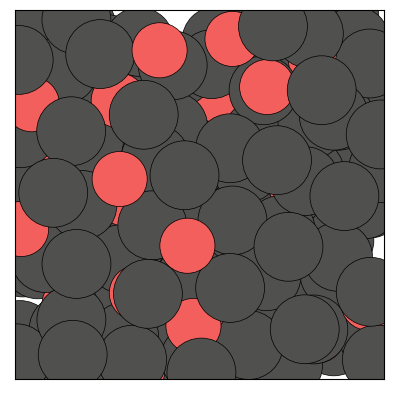

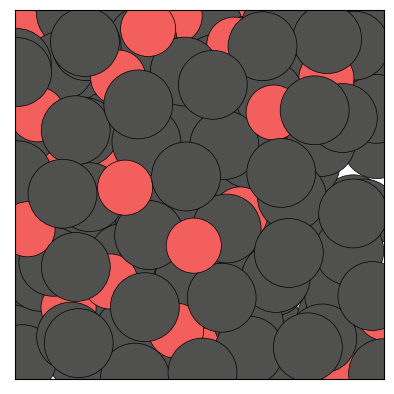

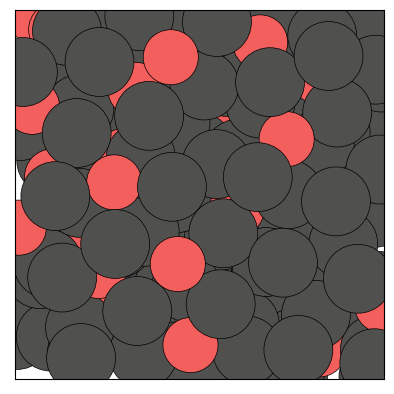

In [30]:
# Open a trajectory file
traj = Trajectory('data/kalj_N150.xyz')
# Adjust radii
traj.set_property('radius', 0.5, "species == 'A'")
traj.set_property('radius', 0.4, "species == 'B'")

# Dhow the first three frames
# (all frames are shown if `frames` is not specified)
# default coloring code uses the species
figs = traj.show(frames=[0,1,2], backend='matplotlib', show=True)

The `Trajectory` class being iterable, one can also show a specific frame by calling `show()` on an element of the trajectory:

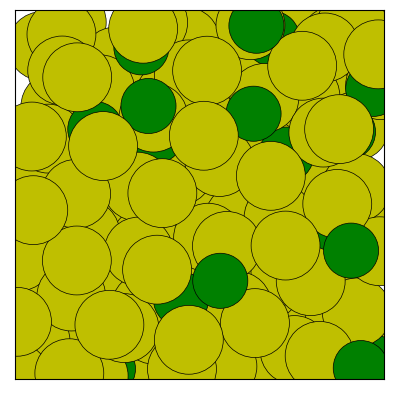

In [31]:
# Show the 5-th frame, change the view, use custom colors
fig = traj[4].show(backend='matplotlib', view='back',
                   palette=['y', 'g'], show=True)

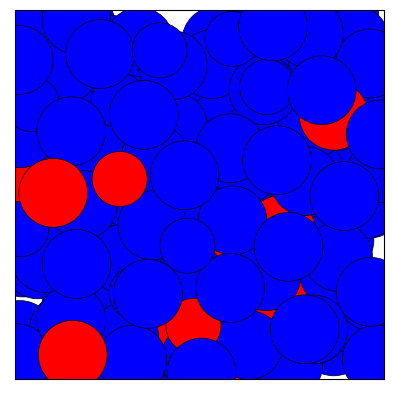

In [32]:
# Color particles according to an arbitrary *discrete* particle property
# (for the example, we randomly assign labels to the particles)
traj[0].set_property('label', 0)
p = [0,15,28,37,41,56,63,72,88,90,104,113,125,137,142]
for pi in p:
    traj[0].particle[pi].label = 1
fig = traj[0].show(color='label', palette=['b', 'r'], show=True)

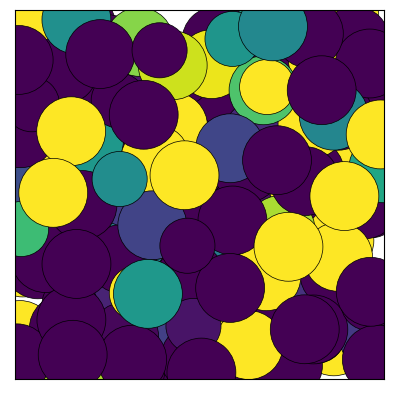

In [33]:
from numpy.random import normal

# Color particles according to an arbitrary *continuous* particle property
# (for the example, we randomly assign a random float property to the particles)
rn = [normal() for i in range(150)]
traj[0].set_property('random', rn)
fig = traj[0].show(color='random', cmap='viridis', show=True)

### Ovito

See the [show_ovito()](../../source/partycls.html#partycls.helpers.show_ovito) function in [partycls.helpers](../../source/partycls.html#module-partycls.helpers) for more information.

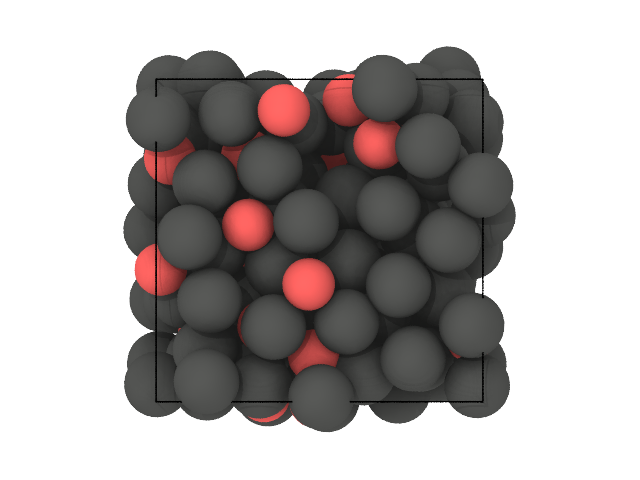

In [34]:
from partycls.trajectory import Trajectory

# Open a trajectory file
traj = Trajectory('data/kalj_N150.xyz')
# Adjust radii
traj.set_property('radius', 0.5, "species == 'A'")
traj.set_property('radius', 0.4, "species == 'B'")

# Show the first frame
traj[0].show(backend='ovito')

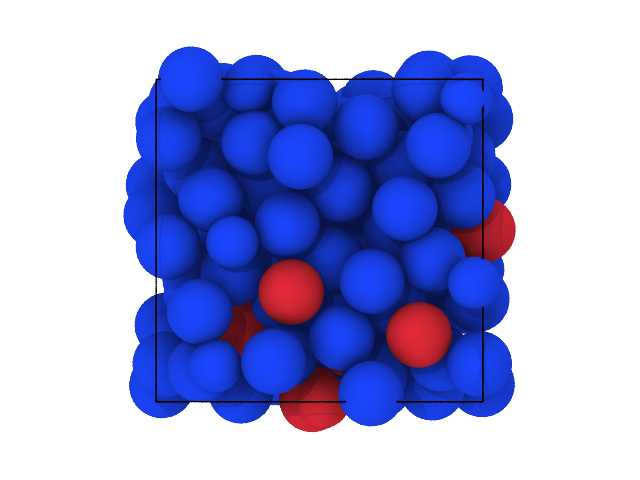

In [35]:
# Color particles according to an arbitrary *discrete* particle property
# (for the example, we randomly assign labels to the particles)
traj[0].set_property('label', 0)
p = [0,15,28,37,41,56,63,72,88,90,104,113,125,137,142]
for pi in p:
    traj[0].particle[pi].label = 1
    
# /!\ Colors must be in RGB format
ovito_colors = [(0.1,0.25,0.9), (0.8,0.15,0.2)]

# Show the first frame
traj[0].show(color='label', backend='ovito', palette=ovito_colors, view='bottom')

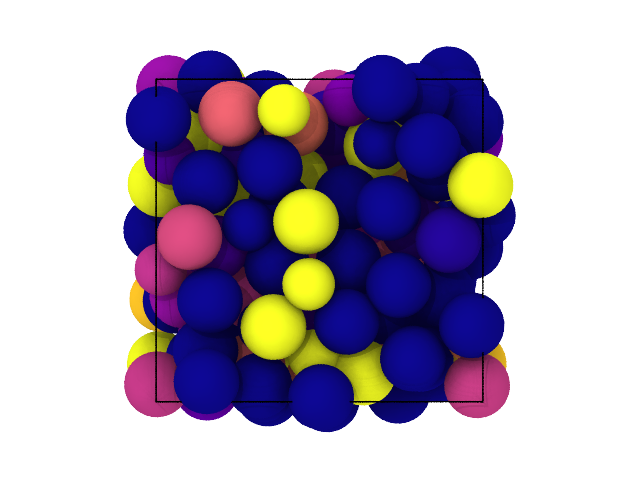

In [36]:
from numpy.random import normal

# color particles according to an arbitrary *continuous* particle property
# (for the example, we randomly assign a random float property to the particles)
rn = [normal() for i in range(150)]
traj[0].set_property('random', rn)
traj[0].show(color='random', backend='ovito', cmap='plasma')

### py3Dmol

See the [show_3dmol()](../../source/partycls.html#partycls.helpers.show_3dmol) function in [partycls.helpers](../../source/partycls.html#module-partycls.helpers) for more information.

<div class="alert alert-warning">
    Warning
    
    This backend works well with small systems, but tends to get pretty slow with larger systems.
</div>

In [37]:
# Open a trajectory file
traj = Trajectory('data/dislocation.xyz')

# Show the first frame
# Default coloring code uses the species
view = traj[0].show(backend='3dmol')
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [38]:
# Color particles according to an arbitrary *discrete* particle property
# (for the example, we randomly assign labels to the particles)
traj[0].set_property('label', 0)
p = [0,5,11,16,20]
for pi in p:
    traj[0].particle[pi].label = 1
view = traj[0].show(backend='3dmol', color='label', palette=['blue', 'red'])
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Writing a trajectory

The class `Trajectory` can also write a trajectory files with the `write()` method.

Once the input trajectory has been loaded at the creation of a `Trajectory` object, any link with the original file is **broken**: changing the current instance of `Trajectory` will have no effect on the original file.

Writing a new trajectory file from the current instance can then be useful for many reasons. For example, convert from a format to another:

In [39]:
# Open XYZ file
traj = Trajectory('data/traj_with_masses.xyz')

# Write the trajectory in RUMD format (as a new file)
traj.write('data/traj_with_masses.xyz.gz', fmt='rumd')

Or write a trajectory file with additional fields that were not present in the original file:

In [40]:
# Open XYZ file
traj = Trajectory('data/traj_with_masses.xyz', additional_fields=['mass'])

# Set custom values for radii of the particles
traj.set_property('radius', 0.5, "species == 'A'")
traj.set_property('radius', 0.4, "species == 'B'")

# Write a new file with both masses and radii
traj.write('data/traj_with_masses_and_radii.xyz', fmt='xyz', additional_fields=['mass', 'radius'])